# RDS Lab 11: Case Study: Predicting employment outcomes based on mental health indictors

We're going to be continuing our case study of a single dataset. The process we'll go through should help you as you work on your projects. The dataset is a survey designed to help draw a connection between mental health and employment outcomes. It was collected by Michael Corley in partnership with SurveyMonkey and published on Kaggle.


In [1]:
import pandas as pd
import numpy as np
np.random.seed(10)

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

import lime
import lime.lime_tabular

## Part 1: Preprocessing the data

We went through the data cleaning process last week, so feel free to just tab through this code. 

In [2]:
# Read in the data 
student_path = "../shared/Lab 10/mental_health_employment_survey.csv"
instructor_path = "../../shared/Lab 10/mental_health_employment_survey.csv"
survey = pd.read_csv(student_path)
survey = survey.loc[1:, ]

# Rename the columns
features = ['respondent_id', 'collector_id', 'survey_start', 'survey_end', 'ip', 'email', 'first_name', 'last_name', 
 'custom_data', 'has_mental_illness', 'education', 'has_computer', 'hospitalized', 'days_hospitalized', 
 'employed', 'legally_disabled', 'internet_access', 'lives_with_parents', 'resume_gap', 'resume_gap_months',
 'total_income', 'unemployed', 'reads', 'welfare_income', 'gets_food_stamps', 'gets_section8', 'times_hospitalized',
 'lack_of_concentration', 'anxiety', 'depression', 'obsessive_thinking', 'mood_swings',  'panic_attacks', 
 'compulsive_behavior', 'tiredness', 'age', 'gender', 'household_income', 'region', 'device_type']
# Create a dictionary to store the new feature name as well as the originl feature name, 
# so that we can easily look up the full original question if we forget what the feature name represents
feat_dict = {}
for i in range(len(features)):
    feat_dict[features[i]] = survey.columns[i]
survey.columns = features

# Drop columns we don't need
survey.drop(["custom_data"], axis=1, inplace=True)
for var in [ 'ip', 'email', 'first_name', 'last_name']:
    # Confirm all rows are missing
    assert sum(survey[var].notna())==0
    # Drop the variable
    survey.drop([var], axis=1, inplace=True)

In [3]:
# Try to cast each variable that we suspect might be numeric, 
# flagging the variable if that doesn't work
for var in ["days_hospitalized", "resume_gap_months", "total_income", "welfare_income", "times_hospitalized", "age", "household_income"]:
    try:
        survey[var]=pd.to_numeric(survey[var])
        print("{} is all numeric.".format(var))
    except:
        print("{} has non numeric values:".format(var))
        print(survey[var].unique())

days_hospitalized is all numeric.
resume_gap_months is all numeric.
total_income is all numeric.
welfare_income is all numeric.
times_hospitalized is all numeric.
age has non numeric values:
['30-44' '18-29' '45-60' '> 60']
household_income has non numeric values:
['$25,000-$49,999' '$50,000-$74,999' '$150,000-$174,999' '$0-$9,999'
 '$100,000-$124,999' '$125,000-$149,999' 'Prefer not to answer'
 '$10,000-$24,999' '$75,000-$99,999' '$200,000+' '$175,000-$199,999']


In [4]:
# Recode hospitalization variables for consistency 
survey.loc[survey.days_hospitalized>0, 'hospitalized' ] = 'Yes'
survey.loc[survey.times_hospitalized>0, 'hospitalized' ] = 'Yes'

# Drop unemployment because it is not consistent with employment
survey.drop('unemployed', axis=1, inplace=True)

In [5]:
# Recode yes-no variables as dummies
for var in ['has_mental_illness', 'has_computer', 'hospitalized','employed', 'legally_disabled', 
            'internet_access', 'lives_with_parents', 'resume_gap', 'reads','gets_food_stamps', 'gets_section8']:
    survey[var] = (survey[var] == 'Yes')
    
for var in ['lack_of_concentration', 'anxiety', 'depression', 'obsessive_thinking', 
            'mood_swings',  'panic_attacks', 'compulsive_behavior', 'tiredness']:
    survey[var] = (survey[var].notna())

In [6]:
# Clean missing values

# For region, treat "missing" as its own category
survey.region = survey.region.fillna("Missing")

# For "days_hospitalized," treat missing as zero
survey.days_hospitalized = survey.days_hospitalized.fillna(0)


In [7]:
survey.head()

,respondent_id,collector_id,survey_start,survey_end,has_mental_illness,education,has_computer,hospitalized,days_hospitalized,employed,...,obsessive_thinking,mood_swings,panic_attacks,compulsive_behavior,tiredness,age,gender,household_income,region,device_type
1,6.630447e+09,168522804.0,01/15/2018 03:45:16 AM,01/15/2018 03:48:24 AM,False,High School or GED,False,False,0.0,False,...,True,False,True,False,False,30-44,Male,"$25,000-$49,999",Mountain,Android Phone / Tablet
2,6.630410e+09,168522804.0,01/15/2018 03:17:52 AM,01/15/2018 03:18:57 AM,True,Some Phd,True,False,0.0,True,...,False,False,True,False,True,18-29,Male,"$50,000-$74,999",East South Central,MacOS Desktop / Laptop
3,6.630402e+09,168522804.0,01/15/2018 03:10:28 AM,01/15/2018 03:12:49 AM,False,Completed Undergraduate,True,False,0.0,True,...,False,False,False,False,False,30-44,Male,"$150,000-$174,999",Pacific,MacOS Desktop / Laptop
4,6.630335e+09,168522804.0,01/15/2018 02:11:16 AM,01/15/2018 02:12:33 AM,False,Some Undergraduate,True,False,0.0,False,...,False,False,False,False,False,30-44,Male,"$25,000-$49,999",New England,Windows Desktop / Laptop
5,6.630290e+09,168522804.0,01/15/2018 01:24:12 AM,01/15/2018 01:26:34 AM,True,Completed Undergraduate,True,True,35.0,True,...,True,True,True,True,True,30-44,Male,"$25,000-$49,999",East North Central,iOS Phone / Tablet


## Part 2:  Building a Model

**The scenario:** You work for a nonprofit organization whose mission is to help individuals with mental health conditions find stable employment. However, you have limited resources, and there are more people seeking your organization’s assistance than you can help. You want your staff to put their time where it will do the most good, so **you decide to help those individuals with the least likelihood of finding employment on their own.** 

To do so, you come across this survey online that relates mental illness and other socioeconomic data points to employment outcomes. You decide to build a model to **predict an individual’s likelihood of being employed based on this survey.** You figure that you can ask individuals seeking your organization’s help to take the survey, generate a prediction based on this model, and decide who to help based on who has the lowest predicted probability of being employed. 


In [8]:
# First, remove total_income and household_income to avoid leakages
survey.drop(['respondent_id', 'household_income', 'total_income'], axis=1, inplace=True)

# Also remove survey-related variables that don't matter as predictors
survey.drop([ 'collector_id', 'survey_start', 'survey_end', 'device_type'], axis=1, inplace=True)

In [9]:
x = survey.drop("employed", axis=1)
y = survey.employed

In [10]:
# Pre-process categorical features in a LIME-friendly way, storing their individual values (see Lab 8)
categorical_features = ["age", "education", "gender", "region"]
categorical_features  = [i for i in range(len(x.dtypes)) if x.dtypes[i]=='object']

categorical_names = {}
for feature in categorical_features:
    # Use label encoder to map categories to numbers
    le = LabelEncoder()
    le.fit(x.iloc[:, feature])
    # Replace the categories with corresponding numbers in the original data
    x.iloc[:, feature] = le.transform(x.iloc[:, feature])
    # Store and print the mappings for reference later
    categorical_names[feature] = le.classes_
    
encoder = ColumnTransformer(transformers=[('get_dummies', OneHotEncoder(), categorical_features)], remainder='passthrough')
encoder = encoder.fit(x)


In [11]:
# Split into train/val/test 70/15/15 
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.85, random_state=16)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=(0.70/0.85), random_state=16)
print("Train size: ", len(x_train))
print("Val size: ", len(x_val))
print("Test size: ", len(x_test))

Train size:  233
Val size:  50
Test size:  51


Okay, now we're ready to train a random forest model, tuning over min_samples_split and the criterion used for splitting

In [12]:
# Set up hyperparamter tuning 
criterion_values =  ["gini", "entropy"]
min_samples_split_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
val_aucs = []
max_val_auc = 0

for criterion in criterion_values:
    
    for min_samples_split in min_samples_split_values:
        
        # Fit a random forest clssifier with these hyperparamters
        model = RandomForestClassifier(criterion=criterion, min_samples_split=min_samples_split, random_state=10)
        model = model.fit(encoder.transform(x_train), y_train)
        
        # Evaluate on the validation set
        y_pred = model.predict_proba(encoder.transform(x_val))[:,1]
        val_auc = roc_auc_score(y_val, y_pred)
        val_aucs.append(val_auc)
        
        # Update best model if this model has the best AUC that we've seen thus far
        if val_auc > max_val_auc:
            
            best_model = model
            best_model_params = {'criterion': criterion, 
                                 'min_samples_split': min_samples_split}
            max_val_auc = val_auc

print("Best model AUC: ", max_val_auc)
print("Best model parameters: ", best_model_params)

Best model AUC:  0.8685714285714285
Best model parameters:  {'criterion': 'gini', 'min_samples_split': 4}


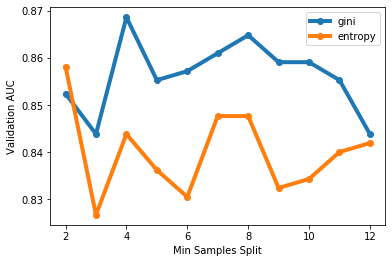

In [13]:
fig, ax = plt.subplots()

for i, criterion in enumerate(criterion_values):
    val_aucs_to_plot = val_aucs[i*int(len(val_aucs)/2):(i+1)*int(len(val_aucs)/2)]
    ax.plot(min_samples_split_values, val_aucs_to_plot, marker='.', markersize=12, linewidth=4, label=criterion)
    
ax.set_xlabel("Min Samples Split")
ax.set_ylabel("Validation AUC")
plt.legend()
plt.show()

## Part 3: Auditing Fairness in the Model Predictions

We're going to explore a few different types of fairness for this model. 

#### Accuracy by Subclass

First, we want to make sure that the model is at *least* as accurate for those with mental illnesses as those without.  Below, calculate the following:
- the overall accuracy 
- the accuracy for those who reported having a mental illness
- the accuracy for those who did not

In [14]:
# Your code here
y_pred = best_model.predict_proba(encoder.transform(x_val))[:,1]

# Overall accuracy

# Those with has_mental_illness=True

# Those with has_mental_illness=False


Overall accuracy:  0.82
With mental illness accuracy:  0.7142857142857143
No mental illness accuracy:  0.8611111111111112


Is this gap in accuracy too big? Probably. (Do keep in mind, however, that our validation set is tiny and thus this estimate is noisy.)

Let's try re-tuning the model, except this time, we'll pick the model that leads the lowest discrepancy in accuracies between the two groups. 

In [15]:
# Set up hyperparamter tuning 
criterion_values =  ["gini", "entropy"]
min_samples_split_values = [2, 3, 4, 5, 6, 7, 8, 9, 10 ]
acc_gaps = []
min_acc_gap = float('inf')

for criterion in criterion_values:
    
    for min_samples_split in min_samples_split_values:
        
        # Fit a random forest clssifier with these hyperparamters
        model = RandomForestClassifier(criterion=criterion, min_samples_split=min_samples_split, random_state=10)
        model = model.fit(encoder.transform(x_train), y_train)
        
        # Evaluate on the validation set
        y_pred = model.predict_proba(encoder.transform(x_val))[:,1]
        # Calculate accuracy separately for those with and without mental illnesses 
        mi_acc = accuracy_score(y_pred[x_val.has_mental_illness==1]>0.5, y_val[x_val.has_mental_illness==1])
        no_mi_acc = accuracy_score(y_pred[x_val.has_mental_illness==0]>0.5, y_val[x_val.has_mental_illness==0])
        # Calculate the gap between the accuracy for those two groups
        gap = no_mi_acc - mi_acc
        acc_gaps.append(gap)
        
        # Update best model if this model has the smallest difference between accuracies that we've seen thus far
        if gap < min_acc_gap:
            best_model = model
            best_model_params = {'criterion': criterion, 
                                 'min_samples_split': min_samples_split}
            min_acc_gap = gap

print("Best model accuracy gap between the two groups: ", min_acc_gap)
print("Best model parameters: ", best_model_params)

Best model accuracy gap between the two groups:  0.019841269841269882
Best model parameters:  {'criterion': 'entropy', 'min_samples_split': 9}


Let's re-evaluate accuracy with this new model. 

In [16]:
y_pred = best_model.predict_proba(encoder.transform(x_val))[:,1]

# Overall accuracy
print("Overall accuracy: ", accuracy_score(y_pred>0.5, y_val))

# Those with has_mental_illness=True
print("With mental illness accuracy: ",  accuracy_score(y_pred[x_val.has_mental_illness==1]>0.5, y_val[x_val.has_mental_illness==1]))

# Those with has_mental_illness=False
print("No mental illness accuracy: ",  accuracy_score(y_pred[x_val.has_mental_illness==0]>0.5, y_val[x_val.has_mental_illness==0]))


Overall accuracy:  0.8
With mental illness accuracy:  0.7857142857142857
No mental illness accuracy:  0.8055555555555556


Overall accuracy has fallen, but now the model does much better for individuals with mental illness.

What are some potential pitfalls of this method of pursuing equal accuracy across subclasses? 

#### Disparate Impact for Sensitive Groups

First, think back to our scenario. *What outcome class is desirable?*

Now, let's see how predictions for that outcome vary by sensitive class. Pick any sensitive characteristic that's of interest to you -- there are lots of options in this dataset! Then calculate the false positive rate ratio and the false negative rate ratio. As you do, think about

- What is the range of these metrics? 
- What is their ideal value?
- What does a false positive and a false negative in this context? Which do you think is worse?

*False Positive Rate Ratio*

$$\frac{FNR_{D = \text{unprivileged}}}{FNR_{D = \text{privileged}}}$$

*False Negative Rate Ratio*

$$\frac{FPR_{D = \text{unprivileged}}}{FPR_{D = \text{privileged}}}$$

In [17]:
def get_ratios(feat, privileged):
    '''Returns the false positive rate and false negative rate, 
       treating feat as the sensitive feature
       and privileged as the privileged class'''
    
    # Get boolean vector marking which observations are of the privileged class
    privileged_obs = x_val[feat] == privileged

    # False negative rate ratio
    fnr_privileged = sum((y_pred[privileged_obs]>0.5) & (y_val[privileged_obs]==0)) / sum(y_val[privileged_obs]==0)
    fnr_unprivileged = sum((y_pred[~privileged_obs]>0.5) & (y_val[~privileged_obs]==0)) / sum(y_val[~privileged_obs]==0)
    print("FNR Ratio: ",  fnr_unprivileged/fnr_privileged)
    
    # False positive rate ratio
    fpr_privileged = sum((y_pred[privileged_obs]<0.5) & (y_val[privileged_obs]==1)) / sum(y_val[privileged_obs]==1)
    fpr_unprivileged = sum((y_pred[~privileged_obs]<0.5) & (y_val[~privileged_obs]==1)) / sum(y_val[~privileged_obs]==1)
    print("FPR Ratio: ", fpr_unprivileged/fpr_privileged)
    return

In [18]:
# Try out some features that are interesting to you here. 

# Pick a feature name
sensitive_feature_name = ""
# Pick a value of that feature that is privileged (treating the feature as binary)
# Recall that we've recoded categorical features using numerical labels, and stored the results in categorical_names
privilege_value = 

get_ratios(sensitive_feature_name, privilege_value)

FNR Ratio:  2.0
FPR Ratio:  0.59375


Which is more important to you? Rectifying any disparities we found, or preserving the (already low) accuracy of this model for all those with mental illness?

## Part 4: Explaining the Model Predictions

In this scenario, we know we're going to need to be able explain to someone why they will or will not receive employment assistance from our nonprofit. LIME can help us do that.

Let's look at the predictions for some individuals in the test set who have a mental illness. 

In [19]:
# Initialize the explainer
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, 
                                                   feature_names=x_train.columns,
                                                   class_names=['Unemployed', 'Employed'],
                                                   categorical_features=categorical_features, 
                                                   categorical_names=categorical_names)

predict_fn = lambda x: model.predict_proba(encoder.transform(x)).astype(float)

# Get test set predictions
y_test_pred =  best_model.predict_proba(encoder.transform(x_test[x_test.has_mental_illness]))[:,1]


Prediction:  Employed


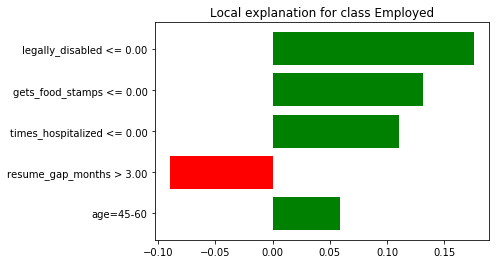

In [20]:
i = 5
exp = explainer.explain_instance((x_test[x_test.has_mental_illness].values[i]), predict_fn, num_features=5)
print("Prediction: ", "Employed" if y_test_pred[i] > 0.5 else "Unemployed")
fig = exp.as_pyplot_figure()